In [1]:
import gzip
import pandas as pd
import pandas_plink as pdpl
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import subprocess
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [3]:
# There are three file types for genetic data that interest us
# Multiple different samples of these files can be found on 1000 Genomes
# In the interest of size and reproducibility we will use just EUR.1 in the beginning
bim, fam, G = pdpl.read_plink("EUR.1.test/1000G.EUR.1")

# This file contains the gene expression data we will be using
gene_expr = pd.read_csv('GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz', compression='gzip', sep='\t')

# We also want to grab the gene annotations
with gzip.open("gene_annot.txt.gz", "rt") as f:
    # Read the file content into a pandas DataFrame
    gene_annotations = pd.read_csv(f, sep="\t")

Mapping files: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


In [4]:
# We want to combine the files so that we have users as rows, and their snps as columns
geno_df = pd.DataFrame(G.compute().transpose())
geno_df.columns = bim['snp']  # Use SNP IDs as columns
geno_df.index = fam['iid']  # Use individual IDs as rows

# Transpose gene expression data so that individual IDs are in the index as well
gene_expr_t = gene_expr.set_index('Gene_Symbol').transpose()

# The data isn't always consistent across all the files, so we want to only pull data we have all the information for
# Extract the individual IDs that match those in fam['iid']
gene_expr_t.index.name = 'iid'
matching_ids = gene_expr_t.index.intersection(fam['iid'])

# Filter both dataframes to only include these matching IDs
geno_df_filtered = geno_df.loc[matching_ids]
gene_expr_filtered = gene_expr_t.loc[matching_ids]

In [5]:
# Randomly select a gene to test:
gene_of_interest = 'ENSG00000152931.6'

# Adjust window according to gene location
# [We will automate this process in the next step]
snps_in_window = bim[(bim['chrom'] == "1") & 
                         (bim['pos'] >= 252566) & 
                         (bim['pos'] <= 1252566)]

# Get the SNP IDs from the filtered SNPs
snp_ids = snps_in_window['snp'].values

# Filter the genotype DataFrame for the SNPs in the window
genotype_data_window = geno_df.loc[:, snp_ids]

# Filter both dataframes to only include these matching IDs
geno_df_filtered = genotype_data_window.loc[matching_ids]
gene_expr_filtered = gene_expr_t.loc[matching_ids]

# Filter the gene expression data for the gene of interest
gene_expr_filtered = gene_expr_t.loc[matching_ids, gene_of_interest]

# Merge the gene expression data with genotype data
merged_df = pd.concat([gene_expr_filtered, geno_df_filtered], axis=1)

# Rename the gene expression column for clarity
merged_df.rename(columns={gene_of_interest: 'gene_expression'}, inplace=True)

# Ensure gene expression values are numeric
y = pd.to_numeric(merged_df['gene_expression'], errors='coerce')

# Iterate over each SNP column in the genotype data (independent variables)
results = {}
for snp in geno_df_filtered.columns:
    X = pd.to_numeric(merged_df[snp], errors='coerce')  # Convert SNP data to numeric
    X = sm.add_constant(X)  # Add an intercept for the linear regression
    
    # Drop rows with missing or invalid data (NaN)
    valid_data = pd.concat([y, X], axis=1).dropna()
    
    # Run the regression only if valid data exists
    if len(valid_data) > 0:
        model = sm.OLS(valid_data['gene_expression'], valid_data.iloc[:, 1:]).fit()  # Use .iloc to access predictors
        
        # Store the result for this SNP
        results[snp] = {
            'p-value': model.pvalues.iloc[1],  # Use .iloc to access the p-value for the SNP
            'beta': model.params.iloc[1],  # Use .iloc to access the beta coefficient for the SNP
            'r_squared': model.rsquared  # R-squared value
        }

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results).transpose()

# Sort by p-value to find significant eQTLs
significant_eqtls = results_df.sort_values('p-value').head()
print("Most Significant Results:")
print(significant_eqtls)
print("\nAll Results:")
print(results_df)

Most Significant Results:
            p-value      beta  r_squared
rs4970420  0.004872 -0.016493   0.022943
rs9442373  0.030045  0.010051   0.013688
rs3748594  0.038706 -0.023893   0.012437
rs3748593  0.052245 -0.022778   0.010973
rs6696281  0.071271 -0.017948   0.009482

All Results:
             p-value      beta  r_squared
rs3094315   0.179067 -0.008622   0.005273
rs3131972   0.150053 -0.009219   0.006048
rs3131969   0.365582 -0.006137   0.002394
rs1048488   0.208763 -0.007981   0.004616
rs3115850   0.223496 -0.007717   0.004330
...              ...       ...        ...
rs1536168   0.104462 -0.018155   0.007689
rs3737717   0.942082 -0.001428   0.000015
rs12103     0.541356 -0.003543   0.001092
rs12142199  0.302081 -0.005895   0.003114
rs34054191  0.759153 -0.003741   0.000275

[161 rows x 3 columns]


In [6]:
# adjust the results for plotting purposes
results_df['neg_log10_p'] = -np.log10(results_df['p-value'])
results_df1 = pd.merge(results_df, snps_in_window, left_index=True, right_on='snp')

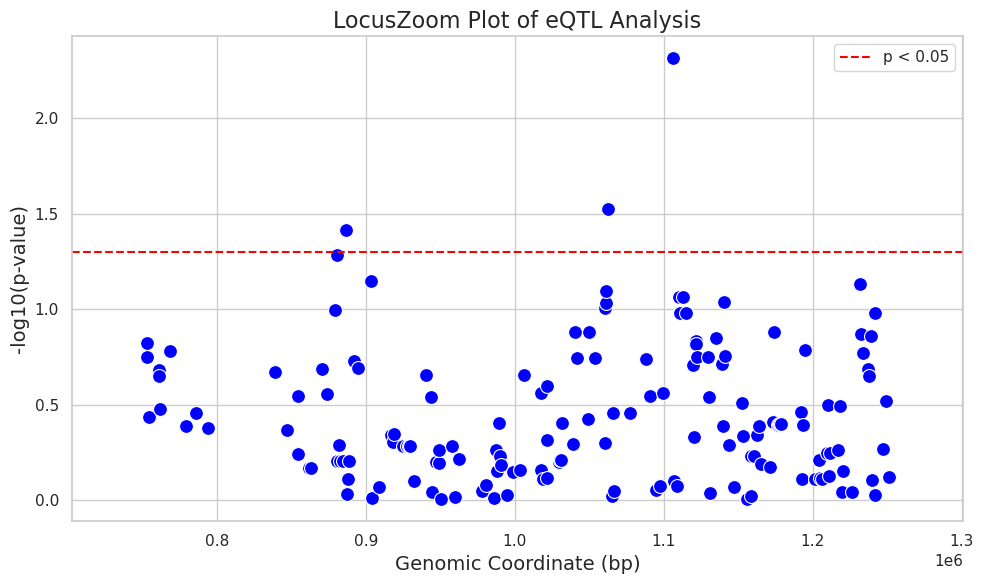

In [7]:
# Create a locus zoom plot to look at results
# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df1, x='pos', y='neg_log10_p', color='blue', s=100)

# Adding labels and title
plt.title('LocusZoom Plot of eQTL Analysis', fontsize=16)
plt.xlabel('Genomic Coordinate (bp)', fontsize=14)
plt.ylabel('-log10(p-value)', fontsize=14)

# Adding a horizontal line for significance threshold (e.g., p < 0.05)
significance_threshold = -np.log10(0.05)
plt.axhline(y=significance_threshold, color='red', linestyle='--', label='p < 0.05')

# Customize x-axis limits (optional)
plt.xlim([results_df1['pos'].min() - 50000, results_df1['pos'].max() + 50000])

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [2]:
# We will now repeat some of the process from above to transition to using chromosome 22
# This will help us in terms of size and time
bim, fam, G = pdpl.read_plink("EUR.22.test/1000G.EUR.22")

# This file contains the gene expression data we will be using
gene_expr = pd.read_csv('GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz', compression='gzip', sep='\t')

# We also want to grab the gene annotations
with gzip.open("gene_annot.txt.gz", "rt") as f:
    # Read the file content into a pandas DataFrame
    gene_annotations = pd.read_csv(f, sep="\t")
    
# We want to combine the files so that we have users as rows, and their snps as columns
geno_df = pd.DataFrame(G.compute().transpose())
geno_df.columns = bim['snp']  # Use SNP IDs as columns
geno_df.index = fam['iid']  # Use individual IDs as rows

# Transpose gene expression data so that individual IDs are in the index as well
gene_expr_t = gene_expr.set_index('Gene_Symbol').transpose()

# The data isn't always consistent across all the files, so we want to only pull data we have all the information for
# Extract the individual IDs that match those in fam['iid']
gene_expr_t.index.name = 'iid'
matching_ids = gene_expr_t.index.intersection(fam['iid'])

# Filter both dataframes to only include these matching IDs
geno_df_filtered = geno_df.loc[matching_ids]
gene_expr_filtered = gene_expr_t.loc[matching_ids]

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 17.82it/s]


In [3]:
# We will ramp up the process above, performing the analysis on a whole chromosome
# I have selected chromosome 14 for our test
chromosome = "22"
chr14_genes = gene_expr[gene_expr['Chr'] == chromosome]['Gene_Symbol']

# Initialize a list to store results for each SNP and gene as rows
chr14_results_list = []

for the_gene in chr14_genes:
    gene_info = gene_expr[gene_expr['Gene_Symbol'] == the_gene]
    snps_in_window = bim[(bim['chrom'] == chromosome) & 
                         (bim['pos'] >= int(gene_info['Coord'].iloc[0])-500000) & 
                         (bim['pos'] <= int(gene_info['Coord'].iloc[0])+500000)]
    
    # Get the SNP IDs from the filtered SNPs
    snp_ids = snps_in_window['snp'].values

    # Filter the genotype DataFrame for the SNPs in the window
    genotype_data_window = geno_df.loc[:, snp_ids]
    
    # Filter both dataframes to only include matching IDs
    geno_df_filtered = genotype_data_window.loc[matching_ids]
    gene_expr_filtered = gene_expr_t.loc[matching_ids]

    # Filter the gene expression data for the gene of interest
    gene_expr_filtered = gene_expr_t.loc[matching_ids, the_gene]

    # Merge the gene expression data with genotype data
    merged_df = pd.concat([gene_expr_filtered, geno_df_filtered], axis=1)

    # Rename the gene expression column for clarity
    merged_df.rename(columns={the_gene: 'gene_expression'}, inplace=True)
    
    # Ensure gene expression values are numeric
    y = pd.to_numeric(merged_df['gene_expression'], errors='coerce')

    for snp in geno_df_filtered.columns:
        X = pd.to_numeric(merged_df[snp], errors='coerce')  # Convert SNP data to numeric
        X = sm.add_constant(X)  # Add an intercept for the linear regression
    
        # Drop rows with missing or invalid data (NaN)
        valid_data = pd.concat([y, X], axis=1).dropna()
    
        # Run the regression only if valid data exists
        if len(valid_data) > 0:
            model = sm.OLS(valid_data['gene_expression'], valid_data.iloc[:, 1:]).fit()  # Use .iloc to access predictors

            if len(model.pvalues) > 1:
                # Append results for this SNP as a row in the results list
                chr14_results_list.append({
                    'Gene': the_gene,
                    'SNP': snp,
                    'p-value': model.pvalues.iloc[1],
                    'beta': model.params.iloc[1],
                    'r_squared': model.rsquared
                })
            else:
                print(f"Insufficient model output for SNP {snp}, skipping.")
                
    print(the_gene + ' completed')

# Convert the list of results into a DataFrame
chr14_results_df = pd.DataFrame(chr14_results_list)

ENSG00000249263.2 completed
ENSG00000224688.1 completed
ENSG00000075240.12 completed
ENSG00000099937.6 completed
ENSG00000099998.12 completed
ENSG00000093072.10 completed
ENSG00000185838.9 completed
ENSG00000226085.2 completed
ENSG00000100427.11 completed
ENSG00000100344.6 completed
ENSG00000040608.9 completed
ENSG00000183741.7 completed
ENSG00000230344.2 completed
ENSG00000161132.6 completed
ENSG00000099910.12 completed
ENSG00000099942.8 completed
ENSG00000231993.1 completed
Insufficient model output for SNP rs8142085, skipping.
ENSG00000100276.8 completed
ENSG00000206140.5 completed
ENSG00000100116.11 completed
ENSG00000213888.2 completed
ENSG00000197077.7 completed
ENSG00000185651.10 completed
ENSG00000100083.14 completed
ENSG00000100031.14 completed
ENSG00000240122.1 completed
ENSG00000131100.8 completed
Insufficient model output for SNP rs8142085, skipping.
ENSG00000242156.1 completed
ENSG00000128254.9 completed
ENSG00000234630.1 completed
ENSG00000100077.7 completed
ENSG000002399

In [45]:
chr14_results_df.to_csv('chr22_eqtl_data.txt', sep='\t', index=False)

In [4]:
sum(chr14_results_df['p-value'] < (0.05))

22978

In [55]:
sum(chr14_results_df['p-value'] < (0.05/(387*633)))

1333

In [81]:
0.05/(387*633)

2.0410579211416863e-07

In [69]:
g2 = chr14_results_df[chr14_results_df['Gene'] == 'ENSG00000100376.7']

In [75]:
sum(g2['r_squared'] > 0.1)

19

In [78]:
# Randomly select a gene to test:
gene_of_interest = 'ENSG00000100376.7'

# Adjust window according to gene location
# [We will automate this process in the next step]
snps_in_window = bim[(bim['chrom'] == "22") & 
                         (bim['pos'] >= 45704849-500000) & 
                         (bim['pos'] <= 45704849+500000)]

# Get the SNP IDs from the filtered SNPs
snp_ids = snps_in_window['snp'].values

# Filter the genotype DataFrame for the SNPs in the window
genotype_data_window = geno_df.loc[:, snp_ids]

# Filter both dataframes to only include these matching IDs
geno_df_filtered = genotype_data_window.loc[matching_ids]
gene_expr_filtered = gene_expr_t.loc[matching_ids]

# Filter the gene expression data for the gene of interest
gene_expr_filtered = gene_expr_t.loc[matching_ids, gene_of_interest]

# Merge the gene expression data with genotype data
merged_df = pd.concat([gene_expr_filtered, geno_df_filtered], axis=1)

# Rename the gene expression column for clarity
merged_df.rename(columns={gene_of_interest: 'gene_expression'}, inplace=True)

# Ensure gene expression values are numeric
y = pd.to_numeric(merged_df['gene_expression'], errors='coerce')

# Iterate over each SNP column in the genotype data (independent variables)
results = {}
for snp in geno_df_filtered.columns:
    X = pd.to_numeric(merged_df[snp], errors='coerce')  # Convert SNP data to numeric
    X = sm.add_constant(X)  # Add an intercept for the linear regression
    
    # Drop rows with missing or invalid data (NaN)
    valid_data = pd.concat([y, X], axis=1).dropna()
    
    # Run the regression only if valid data exists
    if len(valid_data) > 0:
        model = sm.OLS(valid_data['gene_expression'], valid_data.iloc[:, 1:]).fit()  # Use .iloc to access predictors
        
        # Store the result for this SNP
        results[snp] = {
            'p-value': model.pvalues.iloc[1],  # Use .iloc to access the p-value for the SNP
            'beta': model.params.iloc[1],  # Use .iloc to access the beta coefficient for the SNP
            'r_squared': model.rsquared  # R-squared value
        }

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results).transpose()

# Sort by p-value to find significant eQTLs
significant_eqtls = results_df.sort_values('p-value').head()
print("Most Significant Results:")
print(significant_eqtls)
print("\nAll Results:")
print(results_df)

Most Significant Results:
                p-value       beta  r_squared
rs104664   3.256798e-87 -13.171090   0.682510
rs6006992  3.509309e-86 -13.337077   0.678072
rs1569413  3.509309e-86 -13.337077   0.678072
rs136564   3.509309e-86 -13.337077   0.678072
rs470062   3.509309e-86 -13.337077   0.678072

All Results:
             p-value      beta     r_squared
rs6007305   0.665020 -0.254274  5.488456e-04
rs16991944  0.144671 -1.850382  6.210666e-03
rs9626568   0.985343  0.011076  9.882847e-07
rs41487149  0.508560  0.400493  1.278914e-03
rs2071758   0.751509  0.212717  2.935652e-04
...              ...       ...           ...
rs136012    0.690155 -0.297042  4.652439e-04
rs9626448   0.481085 -0.614024  1.452538e-03
rs17653487  0.518470 -0.589020  1.220152e-03
rs3827398   0.619225 -0.450204  7.228947e-04
rs3788677   0.619225 -0.450204  7.228947e-04

[618 rows x 3 columns]


In [79]:
# adjust the results for plotting purposes
results_df['neg_log10_p'] = -np.log10(results_df['p-value'])
results_df1 = pd.merge(results_df, snps_in_window, left_index=True, right_on='snp')

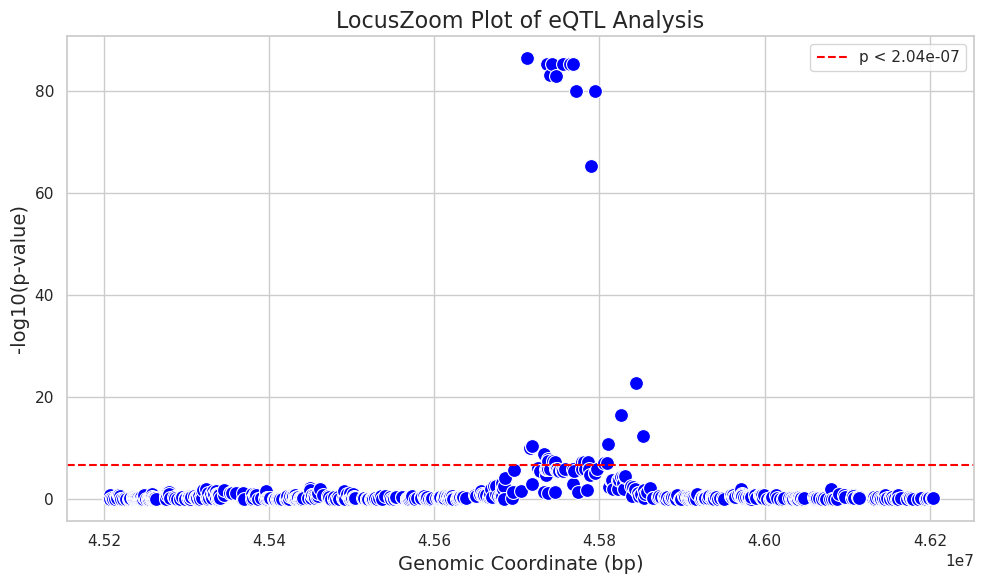

In [82]:
# Create a locus zoom plot to look at results
# Set the aesthetics for the plot
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df1, x='pos', y='neg_log10_p', color='blue', s=100)

# Adding labels and title
plt.title('LocusZoom Plot of eQTL Analysis', fontsize=16)
plt.xlabel('Genomic Coordinate (bp)', fontsize=14)
plt.ylabel('-log10(p-value)', fontsize=14)

# Adding a horizontal line for significance threshold (e.g., p < 0.05)
significance_threshold = -np.log10(0.05/(387*633))
plt.axhline(y=significance_threshold, color='red', linestyle='--', label='p < 2.04e-07')

# Customize x-axis limits (optional)
plt.xlim([results_df1['pos'].min() - 50000, results_df1['pos'].max() + 50000])

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()